In [200]:
%matplotlib nbagg
import pandas as pd
import os.path as path
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy.fft import *
import scipy.signal as signal
from scipy.optimize import curve_fit, minimize
from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties.umath import *
import os
from scipy.optimize import approx_fprime

cc = mpl.rcParams["axes.color_cycle"]
plt.style.use(u'lab_report')

In [50]:
folder = "data/5v/ALL0000/"
def load_scope(num, loc):
    ch1 = pd.read_csv(path.join(loc, "ALL%s/F%sCH1.CSV"%(num, num)), header=None)
    ch2 = pd.read_csv(path.join(loc, "ALL%s/F%sCH2.CSV"%(num, num)), header=None)
    
    data = pd.concat((ch1[[3,4]], ch2[4]), axis=1)
    data.columns = ["t", "v1", "v2"]

    meta_data_1 = {x[1][0]:x[1][1] for x in ch1.iterrows() if x[1][0] is not None}
    meta_data_2 = {x[1][0]:x[1][1] for x in ch2.iterrows() if x[1][0] is not None}
    
    meta_data = [meta_data_1, meta_data_2]

    return data, meta_data

def trigger(data, level, channel):
    start = np.argmax(data[channel] > level)
    t = np.argmax(data[channel][start:] < level) - start
    return data.ix[start:start+2*t]


def fil(x,n):
    pos = x[1:n+1]
    neg = x[-n:]
    
    pos = np.array([u for i,u in enumerate(pos) if i%2 == 0])
    neg = np.array([u for i,u in enumerate(neg[::-1]) if i%2 == 0])

    neg = neg[::-1]
    
    x_fil = np.concatenate((neg, pos)) 
    
    return x_fil

def H_cap(x,tau):
    w = 2*np.pi*x
    return 1/(1+1j*w*tau*1e-6)

def H_curr(x, t):
    w = 2*np.pi*x
    return (1-np.exp(-1j*w*t*1e-9))/(1j*w*t*1e-9)

def H_cap2(x, alpha, beta):
    w = 2*np.pi*x
    return 1./(1 - alpha*1e-12*w**2 + 1j*w*beta*1e-6)

def H_angle2(x,alpha, beta, t):
    return np.angle(H_curr(x, t)) +  np.angle(H_cap2(x, alpha, beta)) 

def H_mag2(x, alpha, beta,t, A):
    w = 2*np.pi*x
    return A*np.abs(H_curr(x, t)) * np.abs(H_cap2(x, alpha, beta)) 

def loss(p, x, y, f):
    y_hat = f(x, *p)
    #plt.plot(x, y_hat)
    #plt.plot(x, y)
    l = np.mean(((unp.nominal_values(y)-y_hat)/unp.std_devs(y))**2)
    #l = np.mean((unp.nominal_values(y)-y_hat)**2)
    return l*1e-5

cons2=({'type': 'ineq', 'fun': lambda x: x[1]**2 - 4*x[0]}, 
      {'type': 'ineq', 'fun': lambda x: x[0]},
      {'type': 'ineq', 'fun': lambda x: x[1]},
      {'type': 'ineq', 'fun': lambda x: x[2]})

<IPython.core.display.Javascript object>


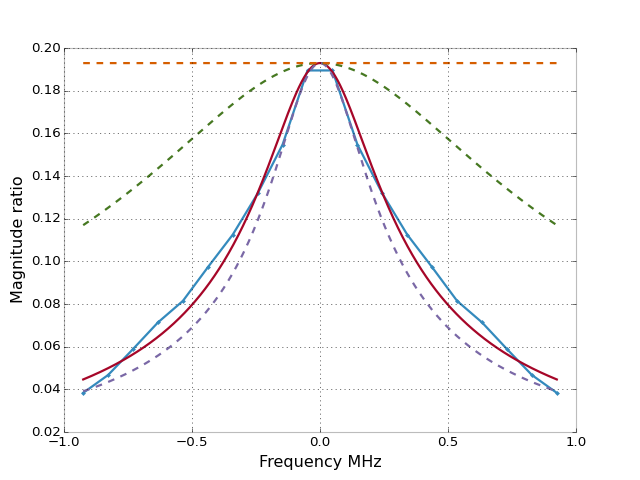

20 20
[0.6919968103014975+/-0.3657378634717135, 0.05096680547007687+/-0.30374281240330925, 9.999912121094319+/-0.003767391561561867, 0.19294563936038292+/-0.7671098844523332, 0.035268866816550115+/-0.19446923719148665, 0.7429636157715744+/-0.18923564290520634]


<IPython.core.display.Javascript object>


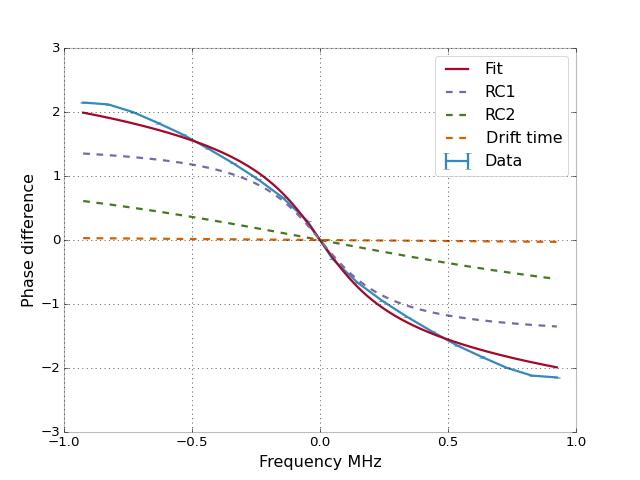

[0.7711570233262727+/-0.706356737152146, 0.12010935785688992+/-0.6387675801149238, 10.000125805002341+/-0.01147798601152162, 0.0926231748785493+/-0.414714647446309, 0.8912663811831626+/-0.25770471077009616]


In [234]:
N = 30
num = "0003"
folder =  "./data/5v"
x_err = 0.1


def load_trigger_filter(num, folder, N, phase):
    data, meta_data = load_scope(num, folder)
    cut = trigger(data, 6 , 'v1')
    f = fil(fftfreq(len(cut), float(meta_data[0]['Sample Interval'])), N)
    n = len(cut['v2'])
    
    i_fft = fil(fft(cut['v1']), N)
    o_fft = fil(fft(cut['v2']), N)
    
    i_re = unp.uarray(np.real(i_fft), np.sqrt(n)*0.05)
    i_im = unp.uarray(np.imag(i_fft), np.sqrt(n)*0.05)
    o_re = unp.uarray(np.real(o_fft), np.sqrt(n)*0.0005)
    o_im = unp.uarray(np.imag(o_fft), np.sqrt(n)*0.0005)
    
    if phase:    
        i = unp.arctan2(i_im, i_re)
        o = unp.arctan2(o_im, o_re)
        
        i = unp.uarray(np.unwrap(unp.nominal_values(i)), unp.std_devs(i))
        o = unp.uarray(np.unwrap(unp.nominal_values(o)), unp.std_devs(o))
        
    else:
        i = unp.sqrt(i_im**2 + i_re**2)
        o = unp.sqrt(o_im**2 + o_re**2)

    return i,o,f

def plot_time_domain(num, folder):
    cut,ff = load_trigger_filter(num, folder)  
    p = os.path.join(folder, "plots/")
    
    try:
        os.mkdir(p)
    except:
        print "Overwriting plots"
        
    fig = plt.figure()
    ax = fig.add_axes([0.1,0.1, 0.8,0.8])
    ax.plot(cut['t']/1e-6, cut['v1'])
    ax.plot(cut['t']/1e-6, cut['v2'])
    fig.savefig(os.path.join(p, num+"_time.pdf"))

def hessian ( x0, calculate_cost_function, args, epsilon=1e-5):
    """
    A numerical approximation to the Hessian matrix of cost function at
    location x0 (hopefully, the minimum)
    """
    # ``calculate_cost_function`` is the cost function implementation
    # The next line calculates an approximation to the first
    # derivative
    f1 = approx_fprime( x0, calculate_cost_function,epsilon, *args) 

    # This is a linear approximation. Obviously much more efficient
    # if cost function is linear
   
    # Allocate space for the hessian
    n = x0.shape[0]
    hessian = np.zeros ( ( n, n ) )
    # The next loop fill in the matrix
    xx = x0
    for j in xrange( n ):
        xx0 = xx[j] # Store old value
        xx[j] = xx0 + epsilon # Perturb with finite difference
        # Recalculate the partial derivatives for this new point
        f2 = approx_fprime( x0, calculate_cost_function, epsilon, *args) 
        hessian[:, j] = (f2 - f1)/epsilon # scale...
        xx[j] = xx0 # Restore initial value of x0        
    return hessian

def plot_ang_fit(ff, delta_phi, tau1, tau2, t, a, b,  ):        
    fig = plt.figure()
    ax = fig.add_axes([0.1,0.1, 0.8,0.8])
    
    w = np.linspace(min(ff), max(ff), 1e3)
    # Data
    ax.errorbar(ff/1e6, unp.nominal_values(delta_phi), 
                yerr=unp.std_devs(delta_phi), label="Data")

    
    #Total model
    ax.plot(w/1e6, H_angle2(w,a.nominal_value,b.nominal_value,t.nominal_value), '-', label="Fit")
    
    #Individual components
    ax.plot(w/1e6, np.angle(H_cap(w, tau1.nominal_value)), '--', label="RC1")
    ax.plot(w/1e6, np.angle(H_cap(w, tau2.nominal_value)), '--', label="RC2")   
    ax.plot(w/1e6, np.angle(H_curr(w, t.nominal_value)), '--', label="Drift time")
    

    plt.xlabel("Frequency MHz")
    plt.ylabel("Phase difference")
    plt.legend()
    
    return fig

        
def ang_fit(num, folder, N, shift, plot=False):

    
    i, o, ff = load_trigger_filter(num, folder, N, phase=True) 
    o = o+shift
    delta_phi = o - i
    
    m = minimize(loss, [0.1,0.1,10], 
                 args=(ff, delta_phi, H_angle2), 
                 constraints=cons2)
    hess = hessian(m.x, loss, (ff, delta_phi, H_angle2) )

    fit = m.x
    errs = np.sqrt(np.diag(np.sqrt(np.dot(hess, m.fun))))
    a,b,t = [ufloat(*x) for x in zip(fit, errs)]
    tau1 = 0.5*(b+sqrt(b**2-4*a))
    tau2 = 0.5*(b-sqrt(b**2-4*a))

    if plot:
        plot_ang_fit(ff, delta_phi, tau1, tau2, t, a, b )
    
    return [tau1, tau2, t, a, b]



def plot_mag_fit(ff, H, tau1, tau2, t, a, b, A):        
            
        fig = plt.figure()
        ax = fig.add_axes([0.1,0.1, 0.8,0.8])
        
        w = np.linspace(min(ff), max(ff), 1e3)
        print len(ff), len(H)
        ax.plot(ff/1e6, unp.nominal_values(H), '.-')
        ax.plot(w/1e6, H_mag2(w,a.nominal_value,b.nominal_value,
                              t.nominal_value,A.nominal_value), '-')
        
        ax.plot(w/1e6, A.nominal_value*np.abs(H_cap(w,np.sqrt(tau1.nominal_value))), '--', )
        ax.plot(w/1e6, A.nominal_value*np.abs(H_cap(w,np.sqrt(tau2.nominal_value))), '--', )
        ax.plot(w/1e6, A.nominal_value*np.abs(H_curr(w, t.nominal_value)), '--', )
        
        
        plt.xlabel("Frequency MHz")
        plt.ylabel("Magnitude ratio")
        
        return fig
    
    
def mag_fit(num, folder, N, plot=False):
    i, o, ff = load_trigger_filter(num, folder, N, phase=False) 
    H = o/i

    m = minimize(loss, [0.01,0.1,10,0.2], args=(ff, H, H_mag2), constraints=cons2, tol=1e-16)
    hess = hessian(m.x, loss, (ff, H, H_mag2) )

    fit = m.x
    errs = np.sqrt(np.diag(np.sqrt(np.dot(hess, m.fun))))
    a,b,t,A = [ufloat(*x) for x in zip(fit, errs)]
    
    tau1 = 0.5*(b+sqrt(b**2-4*a))
    tau2 = 0.5*(b-sqrt(b**2-4*a))

    if plot:
        plot_mag_fit(ff, H, tau1, tau2, t, a, b,A)        


    return [tau1, tau2, t, A, a, b]


print mag_fit("0003", "./data/5v", 20, True)
print ang_fit("0003", "./data/5v", 20, 2*np.pi, True)


In [ ]:
cutoff = [ang_fit("0003", "./data/5v", n, 2*np.pi, False) for n in range(5,60)]
plt.figure()
plt.plot(range(5,60), [x[0].nominal_value for x in cutoff], '.' )
plt.plot(range(5,60), [x[1].nominal_value for x in cutoff], '.' )
plt.plot(range(5,60), [x[2].nominal_value for x in cutoff], '.' )

<IPython.core.display.Javascript object>


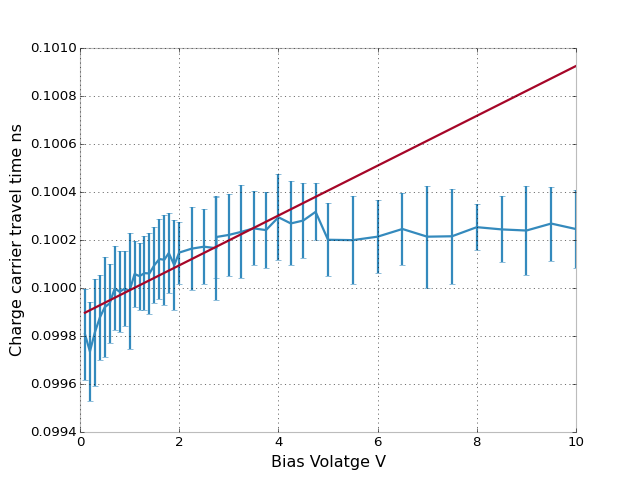

961.901638264


In [256]:
folder = "./data/Photodiode Voltage Bias Against Data Set"
run = [("00"+str(i), 10, 2*np.pi) for i in range(16, 59)] 

#bias = [ang_fit(x[0], folder, x[1], x[2], False) for x in run]

v_b = np.array([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00, 1.10, 1.20, 1.30, 1.40, 1.50, 1.60, 1.70, 1.79, 1.90, 2.00, 2.25, 2.50, 2.75, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50, 4.75, 5.00, 5.50, 6.00, 6.50, 7.00, 7.50, 8.00, 8.50, 9.00, 9.50, 10.00])
t = np.array([x[2].nominal_value for x in bias])
t_err = [x[2].std_dev for x in bias]

def t_r_model(x, v_bi, mu, t_cut, W_d) :
    v = mu*(v_bi+x)/W_d
    T = W_d/v
    
    return np.where(T < t_cut, t_cut, T)

fit = curve_fit(lambda x, m,c:m*x+c, v_b[:-11], 1./t[:-11])
plt.figure()
plt.errorbar(v_b, unp.nominal_values(unp.uarray(t,t_err)**-1), unp.std_devs(unp.uarray(t,t_err)**-1))
plt.plot(v_b, fit[0][0]*v_b+fit[0][1], '-')

print fit[0][1]/fit[0][0]

#plt.plot(v_b, t**-1, '.')
#plt.plot(v_b, np.log(t), '.')



#plt.errorbar(v_b, t,t_err,None,'.')
plt.xlabel("Bias Volatge V")
plt.ylabel("Charge carrier travel time ns")
plt.savefig("current.pdf")

<IPython.core.display.Javascript object>


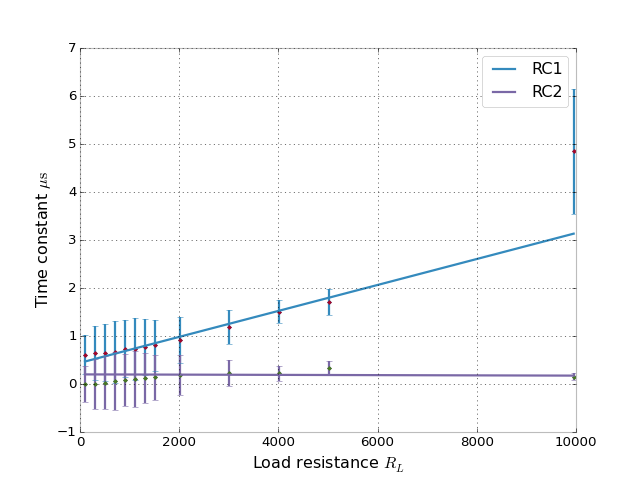

C1 = (2.7+/-0.6)e+02
R_s1 = (1.6+/-0.9)e+03
m2 = (-0.3+/-1.7)e-05
c2 = 0.20+/-0.13


In [244]:
folder = "./data/Resistance Against Data Set"
run = [("%04d"%(i), 30, 2*np.pi) for i in range(1,14)]  
run[1] = (run[1][0], run[1][1], 0)

#run[11] = (run[11][0], 20, 2*np.pi)
run[12] = (run[12][0], 20, 2*np.pi)



#i=11
##x = run[i]
#res[i] = ang_fit(x[0], folder, x[1],x[2], True)


res = [ang_fit(x[0], folder, x[1],x[2], False) for x in run]

r = np.array([100.72, 299.80, 500.0, 699.5, 898.7, 1103.3, 1302.4, 1502.6, 2006.6, 3009.9, 4014, 5022, 9953, 49730, 19900])
tau1 = [x[0].nominal_value for x in res]
tau1_err = [x[0].std_dev for x in res]
tau1_err[12]*=4
tau2 = [x[1].nominal_value for x in res]
tau2_err = [x[1].std_dev for x in res]

t = [x[2].nominal_value for x in res]
t_err = [x[2].std_dev for x in res]


r = r[:-2]

f1 = curve_fit(lambda x,m,c :m*x+c, r, tau1, sigma=tau1_err, absolute_sigma=True )
f2 = curve_fit(lambda x,m,c :m*x+c, r, tau2, sigma=tau2_err, absolute_sigma=True )

plt.figure()


plt.errorbar(r, tau1, tau1_err, fmt='.')
plt.plot(r, tau1, '.')
plt.plot(r, f1[0][0]*r+f1[0][1], color=cc[0], label="RC1")

plt.errorbar(r, tau2, tau2_err, fmt='.')
plt.plot(r, tau2, '.')
plt.plot(r, f2[0][0]*r+f2[0][1], color=cc[2], label="RC2")

plt.legend()
plt.xlabel("Load resistance $R_L$")
plt.ylabel("Time constant $\mathrm{\mu s}$")

plt.savefig("RC.pdf")
m1, c1 = [ufloat(x[0], x[1]) for x in zip(f1[0], np.sqrt(np.diag(f1[1])))]
print "C1 = " + str(m1*1e-6/1e-12)
print "R_s1 = " + str(c1/m1)


m2, c2 = [ufloat(x[0], x[1]) for x in zip(f2[0], np.sqrt(np.diag(f2[1])))]
print "m2 = " + str(m2)
print "c2 = " + str(c2)

<IPython.core.display.Javascript object>


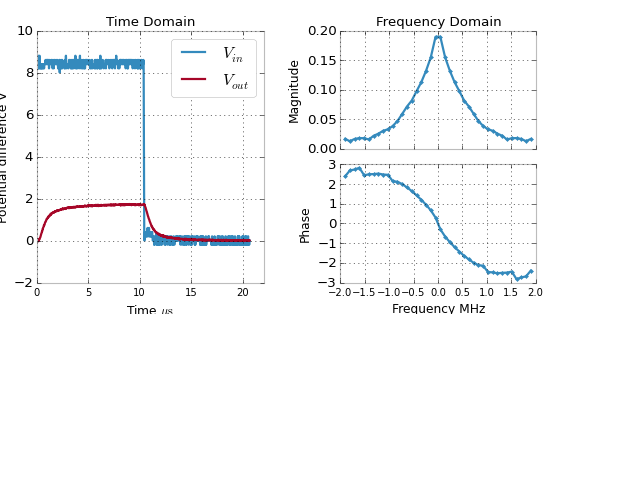

In [134]:
N = 40
num = "0003"
folder =  "./data/5v"
data, meta_data = load_scope(num, folder)
cut = trigger(data, 6 , 'v1')

f = fftfreq(len(cut), float(meta_data[0]['Sample Interval']))
ff =  fil(f, N)
in_phase = np.unwrap(np.angle(fil(fft(cut['v1']), N)))
out_phase = np.unwrap(np.angle(fil(fft(cut['v2']), N)))+2*np.pi
delta = out_phase - in_phase
in_mag = np.abs(fil(fft(cut['v1']), N))
out_mag = np.abs(fil(fft(cut['v2']), N))
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['xtick.labelsize'] = 9

fig = plt.figure()
fig.set_size_inches(18./2.54, 10/2.54)
ax = fig.add_axes([0.065,0.1, 0.4,0.8])
ax.plot(cut['t']/1e-6, cut['v1'], label="$V_{in}$")
ax.plot(cut['t']/1e-6, cut['v2'], label="$V_{out}$")
ax.set_xlim(0,22)
ax.set_xlabel("Time $\mathrm{\mu s}$")
ax.set_ylabel("Potential difference V ")
ax.set_title("Time Domain")
ax.legend()


ax = fig.add_axes([0.6,0.1, 0.345,0.375])
ax.set_ylabel("Phase")
ax.plot(ff/1e6, out_phase, '.-')
#ax.plot(ff/1e6, , '.-')
ax.set_xlabel("Frequency MHz")

ax = fig.add_axes([0.6,0.525, 0.345,0.375])
ax.set_xticklabels([])
ax.set_ylabel("Magnitude")
ax.set_title("Frequency Domain")
plt.plot(ff/1e6, out_mag , '.-')
#plt.plot(ff/1e6, out_mag, '.-')
#fig.savefig("example.pdf")

<IPython.core.display.Javascript object>


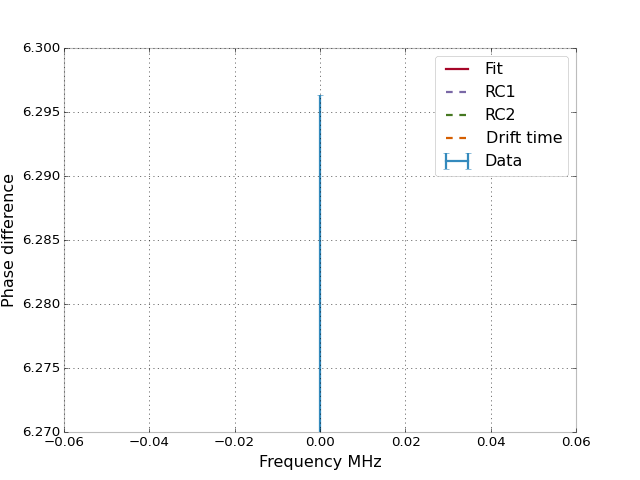

<IPython.core.display.Javascript object>


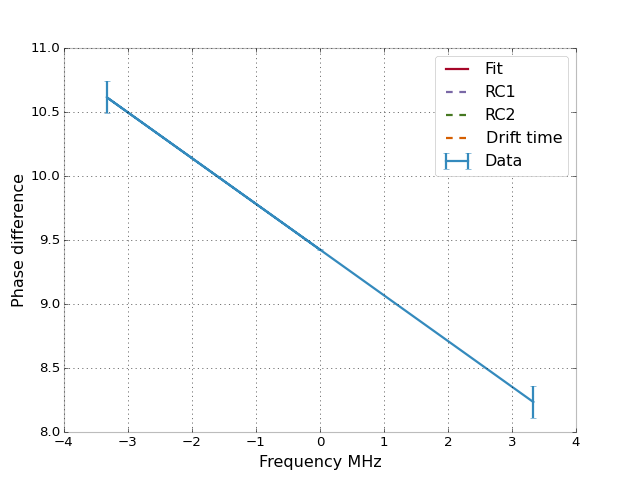

<IPython.core.display.Javascript object>


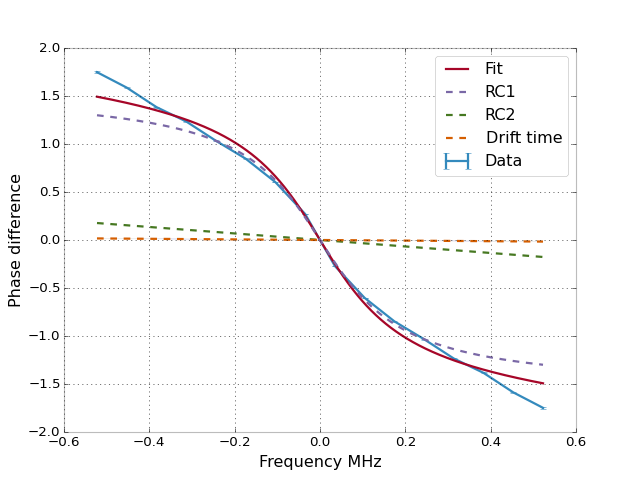

<IPython.core.display.Javascript object>


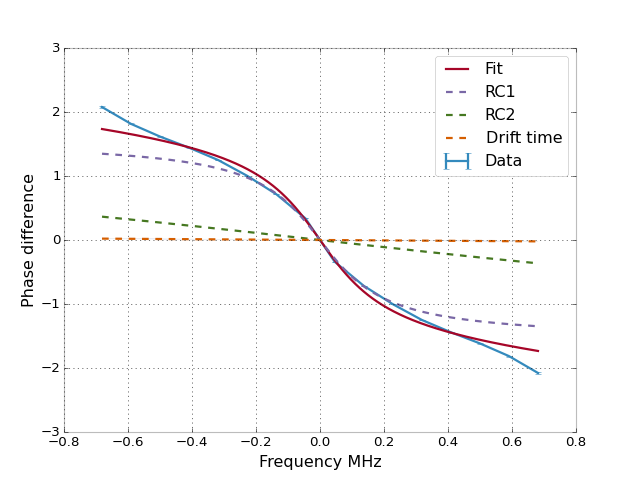

<IPython.core.display.Javascript object>


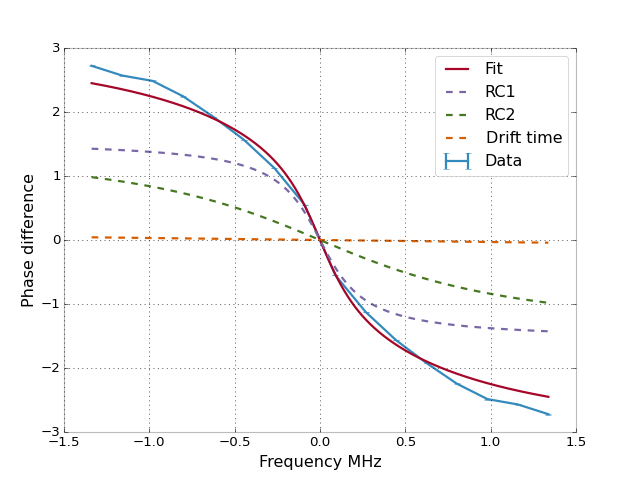

<IPython.core.display.Javascript object>


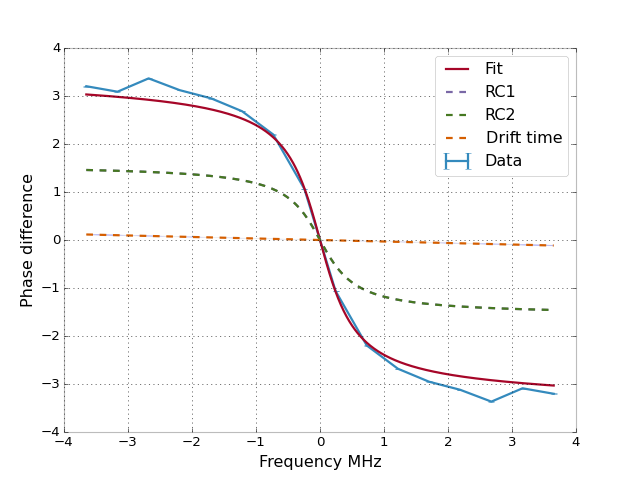

<IPython.core.display.Javascript object>


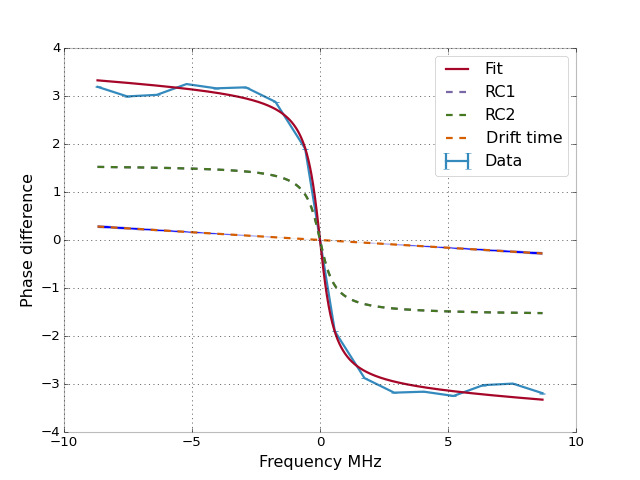

<IPython.core.display.Javascript object>


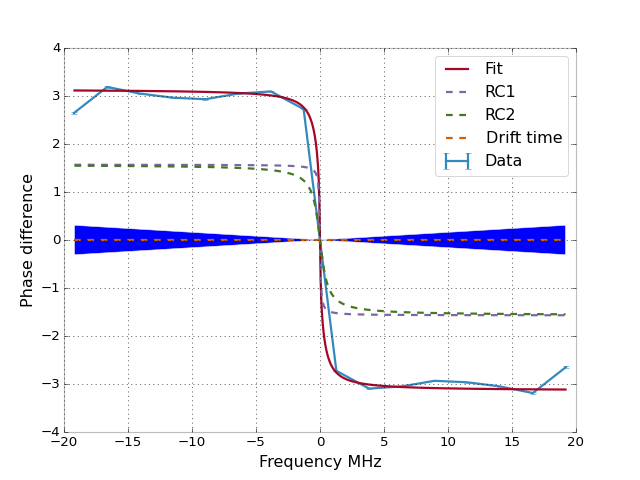

<IPython.core.display.Javascript object>


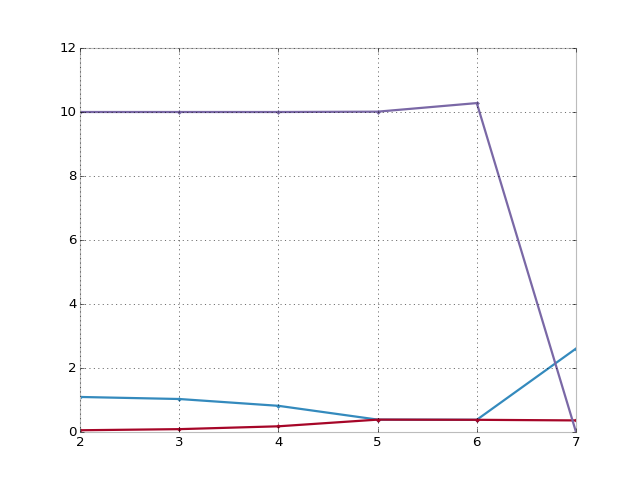

In [214]:

folder = "./data/3v"
run = [("00"+str(i), 15, 2*np.pi) for i in range(11, 19)] 

freq = [ang_fit(x[0], folder, x[1], x[2], True) for x in run]

tau1 = [x[0].nominal_value for x in freq]
tau2 = [x[1].nominal_value for x in freq]
t = [x[2].nominal_value for x in freq]




plt.figure()
plt.plot(range(len(freq)),tau1,'.-')
plt.plot(range(len(freq)),tau2,'.-')
plt.plot(range(len(freq)),t,'.-')